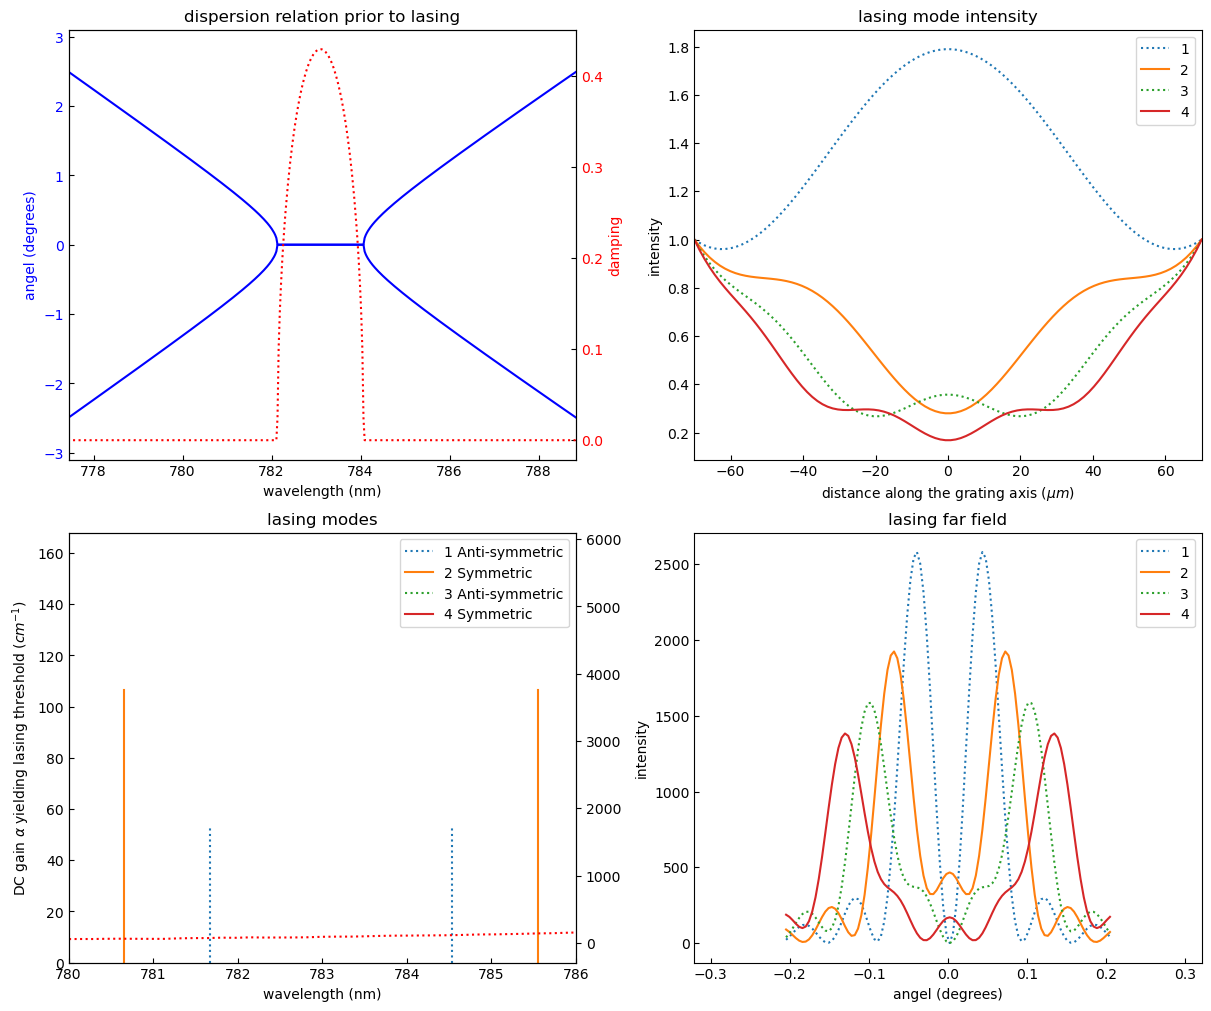

In [8]:
ax=modesfinite2(neff1=1.922,neff2=1.942,duty=0.4, L=140e-6,period=405.75e-9)
ax[1,0].set_xlim(780,786);

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import optimize
import os

def g(gl,kl):
    return kl*np.sinh(gl)-1j*gl
def g1(gl,kl):
    return kl*np.cosh(gl)-1j
def g2(gl,kl):
    return kl*np.sinh(gl)

def fouriercomp(neff1,neff2,duty,dg):
    n0=neff1+duty*(neff2-neff1)
    dn=(neff2**2-neff1**2)/n0
    n1=(2*dn**2*dg*np.sin(np.pi*duty))**2
    n2=dn/np.pi*np.sin(2*np.pi*duty)
    return n0,np.real(n1),n2

def dispersion2(neff1=1.8,neff2=1.7,gain1=1.1,gain2=0.95):
    n,n1=(neff1+neff2)/2,(neff1-neff2)/2
    a,a1=(gain1+gain2)/2,(gain1-gain2)/2
    kapa=n1+0.5j*a1
    abskapa=np.abs(kapa)
    delta=np.linspace(-2*abskapa,2*abskapa,500)
    gamma1=np.sqrt(kapa**2+(a-1.0j*delta)**2)
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    ax.plot(delta/abskapa,np.imag(gamma1)/abskapa,c='blue')
    ax.plot(delta/abskapa,-np.imag(gamma1)/abskapa,c='blue')
    ax.set_xlabel(r'$\delta / |\kappa |$')
    ax.set_ylabel(r'$Im(\gamma) / | \kappa |$')
    ax.text(0,1.5,r'neff$_1$ ='+str(neff1))
    ax.text(0,1.4,r'neff$_2$ ='+str(neff2))
    ax.text(0,1.3,r'$\alpha_1$ ='+str(gain1))
    ax.text(0,1.2,r'$\alpha_2$ ='+str(gain2))
    ax.set_xlim(-2,2)
    ax.tick_params(direction='in')
    
def modesfinite(kL=-1j,maxmodes=4):
    """
    Aim:
        Calculates the lasing treshold for a set of modes as a funtion of the dimensionless parameter kL
    parameters:
        * kL: 
        * maxmodes: maximum number of modes to be plotted
    returns:
        the ax op a plotof the modes. The axes can be replotted or rescaled
    """
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    lstl=['-',':']
    SA=['Symmetric','Anti-symmetric']
    if np.real(kL)==0.0:
        kL2=-np.imag(kL)
        aa=[0]+[(0.9+2*m)*1j  for m in range(1,12)]
        kapaLmax=[1]+[abs(np.real((np.pi*a/2)/np.sinh(np.pi*a/2)))*0.997 for a in aa[1:] ]
        index=next(x for x, val in enumerate(kapaLmax)  if val > kL2)
        aa=aa[index:index+maxmodes]
        kapaLmax=kapaLmax[index:index+maxmodes]
        testy=np.linspace(0.01,20,1500)  
        mode=[i for i in range(index,index+maxmodes)]
        gammaL1w=[optimize.newton(g, np.interp(kL2, np.real((-1)**mm*(testy+np.pi*ar/2)/np.sinh(testy+np.pi*ar/2)), testy+np.pi*ar/2), fprime=g1,fprime2=g2, args=(-kL*(-1)**mm, )) for mm,kLm,ar in zip(mode,kapaLmax,aa)]
    else:
        mode=[i for i in range(1,maxmodes+1)]  
        gammaL1w=[optimize.newton(g,mm*(2/np.abs(kL)**0.5+1j*np.pi), fprime=g1,fprime2=g2, args=(-kL*(-1)**mm, )) for mm in mode]                
    for mm,gL,color in zip(mode,gammaL1w,[c for c in mcolors.TABLEAU_COLORS][:maxmodes]):
            xx=(-1)**mm*1j*kL*np.cosh(gL)
            ax.plot([np.imag(-xx)/np.pi,np.imag(-xx)/np.pi],[0,np.real(xx)],c=color,linestyle=lstl[mm%2],label=str(mm)+' '+SA[mm%2]);
            ax.plot([np.imag(xx)/np.pi,np.imag(xx)/np.pi],[0,np.real(xx)],c=color,linestyle=lstl[mm%2]);
    ax.set_xlabel(r'$\delta$ L/ $\pi$')
    ax.set_ylabel(r'$\alpha$ L')
    ax.set_xlim(-maxmodes-np.abs(kL)/np.pi,maxmodes+np.abs(kL)/np.pi)
    ax.set_ylim(0,)
    ax.tick_params(direction='in')
    ax.legend()
    return ax;

def modesfinite2(neff1=1.7,neff2=1.8,duty=0.27, L=8e-6,period=410e-9,dg=0,maxmodes=4,asefile="77K/NDF5-6_Poldegrees9-  23.csv",dispfile="",minwl=700, maxwl=900, maxangle=20): # even modes are symmetric (q=1), antisymmetric modes are not radiating to the surface
    """
    Aim:
        Calculates the dispersion relation and the lasing treshold for a set of modes 
    parameters:
        * neff1: [complex number] effective refractive index of the propagating mode not part of the duty 
        * neff2: [complex number] effective refractive index of the propagating mode part of the duty 
        * duty: fraction [0..1] of period corresponding to neff2
        * L :[m] total length of the active grating
        * period : [m] period of the grating
        * dg : [m] step heigth corresponding to duty
        * maxmodes: maximum number of modes to be plotted
        * asefile: luninescence spectrum to be plotted on top of the lasing modes {ax[1,0]}
        * dispfile:["*.png"] image file to be plotted on top of the dispersion relation {ax[0,0]}
        * minwl: [nm] only to be used for plotting display file: minimal wavelength on the x-axis of dispfile
        * maxwl: [nm] only to be used for plotting display file: maximal wavelength on the x-axis of dispfile
        * maxangle: [degree] only to be used for plotting display file: maximal angle on the y-axis of dispfile. the angle of the dispersion relation is assumed to be symmetric.
    returns:
        the ax op a plotof the modes. The axes can be replotted or rescaled
    """
    n0,n1,n2=fouriercomp(neff1,neff2,duty,dg)
    n00=np.abs(n0)
    kapa=(n2+1j*n1/period)/period
    abskapa=np.abs(kapa)
    delta=np.linspace(-2*abskapa-12/L,2*abskapa+12/L,500)
    gamma1=np.sqrt(kapa**2+(2*(np.imag(n0)-n1)/period*np.pi-1.0j*delta)**2)
    kL=kapa*L
    fig, ax = plt.subplots(2,2,figsize=(12,10), constrained_layout=True)
    lstl=['-',':']
    SA=['Symmetric','Anti-symmetric']
    ax[0,0].plot(1e9*n00/(1/period+delta/np.pi/n00),np.imag(gamma1)*period/np.pi*180,c='blue')
    ax[0,0].plot(1e9*n00/(1/period+delta/np.pi/n00),-np.imag(gamma1)*period/np.pi*180,c='blue') 
    ax2 = ax[0,0].twinx()
    ax2.plot(1e9*n00/(1/period+delta/np.pi/n00),np.real(gamma1)*period/np.pi*180,c='red',linestyle=lstl[1])
    ax2.set_ylabel('damping', color='red')  
    ax2.tick_params(direction='in',axis='y', labelcolor='red')    
    if np.real(kL)==0.0:
        kL2=-np.imag(kL)
        aa=[0]+[(0.9+2*m)*1j  for m in range(1,12)]
        kapaLmax=[1]+[abs(np.real((np.pi*a/2)/np.sinh(np.pi*a/2)))*0.997 for a in aa[1:] ]
        index=next(x for x, val in enumerate(kapaLmax)  if val > kL2)
        aa=aa[index:index+maxmodes]
        kapaLmax=kapaLmax[index:index+maxmodes]
        testy=np.linspace(0.01,20,1500)
        mode=[i for i in range(index,index+maxmodes)]
        gammaL1w=[optimize.newton(g, np.interp(kL2, np.real((-1)**mm*(testy+np.pi*ar/2)/np.sinh(testy+np.pi*ar/2)), testy+np.pi*ar/2), fprime=g1,fprime2=g2, args=(-kL*(-1)**mm, )) for mm,kLm,ar in zip(mode,kapaLmax,aa)]
    else:
        mode=[i for i in range(1,maxmodes+1)]
        gammaL1w=[optimize.newton(g,mm*(2/np.abs(kL)**0.5+1j*np.pi), fprime=g1,fprime2=g2, args=(-kL*(-1)**mm, )) for mm in mode]                

    zz=np.linspace(-0.5,0.5,100)
    for mm,gL,color in zip(mode,gammaL1w,[c for c in mcolors.TABLEAU_COLORS][:maxmodes]):
        xx=(-1)**mm*1j*kL*np.cosh(gL)-1j*n1*(np.pi/period)**2
        wlm=1e9*n00/(1/period+np.imag(xx)/np.pi/n00/L)
        wlp=1e9*n00/(1/period-np.imag(xx)/np.pi/n00/L)
        ax[1,0].plot([wlm,wlm],[0,np.real(xx)/L*1e-2],c=color,linestyle=lstl[mm%2],label=str(mm)+' '+SA[mm%2]);
        ax[1,0].plot([wlp,wlp],[0,np.real(xx)/L*1e-2],c=color,linestyle=lstl[mm%2]);
        I=np.abs(np.sinh(gL*(zz+0.5)))**2+np.abs(np.sinh(gL*(zz-0.5)))**2  
        Io=I[0]
        ax[0,1].plot(zz*L*1e6,I/Io,label=str(mm),c=color,linestyle=lstl[mm%2])
        ax[1,1].plot(zz/L/1e6/np.pi*180,np.abs(np.fft.fftshift(np.fft.fft((np.sinh(gL*(zz+0.5))-(-1)**mm*np.sinh(gL*(zz-0.5)))/np.sqrt(Io),n=1500))[700:800])**2,label=str(mm),c=color,linestyle=lstl[mm%2])
    if asefile!="":
        fn=os.getcwd() + "/FAPI-PMAI_120nm_Full_ThinITO_LED_spectra/" + asefile
        ase=np.array([i[5:]  for i in np.genfromtxt(fn,delimiter=',',skip_header=1)]).T
        ax[1,0].twinx().plot(ase[0],ase[1],c='red',linestyle=lstl[1])
    if dispfile!="":
        fn2=os.getcwd() + "/disp_png/" + dispfile
        ax[0,0].imshow(plt.imread(fn2, format='png'), extent=[minwl, maxwl, -maxangle, maxangle])
    ax[0,0].set_xlabel(r'wavelength (nm)')
    ax[0,0].set_ylabel(r'angel (degrees)',color='blue')
    ax[0,0].tick_params(direction='in')
    ax[0,0].tick_params(axis='y', labelcolor='blue')  
    ax[0,0].set_title("dispersion relation prior to lasing")
    ax[0,0].set_xlim(1e9*n00/(1/period+1.2*abskapa/np.pi/n00+2/L),1e9*n00/(1/period-1.2*abskapa/np.pi/n00-2/L))   
    ax[1,0].set_xlabel(r'wavelength (nm)')
    ax[1,0].set_ylabel(r'DC gain $\alpha$ yielding lasing threshold ($cm^{-1}$)')
    ax[1,0].set_title("lasing modes")
    ax[1,0].tick_params(direction='in')
    ax[1,0].set_xlim(1e9*n00/(1/period+1.2*abskapa/np.pi/n00+2/L),1e9*n00/(1/period-1.2*abskapa/np.pi/n00-2/L))
    ax[1,0].set_ylim(0,)
    ax[0,1].set_title("lasing mode intensity")
    ax[0,1].set_xlabel(r'distance along the grating axis ($\mu m$)')
    ax[0,1].set_ylabel(r'intensity')
    ax[0,1].set_xlim(-0.5*L*1e6,0.5*L*1e6)
    ax[0,1].tick_params(direction='in');
    ax[1,1].set_title("lasing far field")
    ax[1,1].set_xlabel(r'angel (degrees)')
    ax[1,1].set_ylabel(r'intensity')
    ax[1,1].set_xlim(-1.0*n00*period/L/np.pi*180,1.0*n00*period/L/np.pi*180)
    ax[1,1].tick_params(direction='in')
    ax[0,1].legend()
    ax[1,1].legend()
    ax[1,0].legend()
    return ax;

def matrix(gL,kL,bL,theta=0,Vlsign=1): # work in progress, see< cite id="kvhuf"><a href="#DOI|10.1002/0470856238">(H. Ghafouri–Shiraz)</a></cite> page 87
    E=np.exp(gL)
    vL=np.emath.sqrt(gL**2-kL**2+1j*0.0)*Vlsign  # sign of real part of sqrt is not controlled in python and jumps!!!
    ro=1j*kL/(vL+gL)
    t11=(E-ro**2/E)*np.exp(-1j*bL)/(1-ro**2)*np.exp(1j*theta)
    t12=-ro*(E-1/E)*np.exp(-1j*bL)/(1-ro**2)*np.exp(-1j*theta)
    t21=ro*(E-1/E)*np.exp(1j*bL)/(1-ro**2)*np.exp(1j*theta)
    t22=-(ro**2*E-1/E)*np.exp(1j*bL)/(1-ro**2)*np.exp(-1j*theta)
    return np.array([[t11,t12],[t21,t22]])
     
def steped_long_array(L=[125e-6,50e-6,50e-6,125e-6]):
    """
    Aim:
        Calculates the dispersion relation and the lasing treshold for a set of modes 
    parameters:
        * L: lengths of the different parts of the structure [non-gain,gain,gain,non-gain]
        * ka: kapa of the gain medium
        * kf: kapa of the non-gain medium
        * b: beta of the period
        * theta: phase jump in the middle of the gain medium
    returns:
        m22 parameter of the matrix, which should get zero to get lasing
    """
    r1=np.matmul(matrix(gL=g*L[2],kL=ka*L[2],bL=b*L[2],theta=0),matrix(gL=g*L[3],kL=kf*L[3],bL=b*L[3],theta=0))
    r2=np.matmul(matrix(gL=gL/2,kL=kL/2,bL=b*L[1],theta=theta),r1)
    r=np.matmul(matrix(gL=gL/2,kL=kL/2,bL=b*L[0],theta=0),r2)
    return r[1,1]


In [60]:
kL=1.9
bL=100*np.pi
for theta in np.linspace(0,np.pi,3):
    for gL in np.linspace(0,0.1,3):  
        r=np.matmul(matrix(gL=gL/2,kL=kL/2,bL=bL,theta=theta),matrix(gL=gL/2,kL=kL/2,bL=bL,theta=0))
        print(r[1,1])
    print()

(1+3.928773447456944e-15j)
(1.001250260438369-1.9001334827485958j)
(1.0050041680558137-1.9005304552765414j)

(3.9900057874143115e-15-1j)
(-1.9001334827485814+0.8041258125665072j)
(-1.900530455276543+0.8015005000892913j)

(-1-4.051238127371679e-15j)
(-1.0012502604383693+1.900133482748596j)
(-1.0050041680558142+1.9005304552765414j)



In [59]:
kL=-1.9j
bL=100*np.pi
for theta in np.linspace(0,np.pi,3):
    for gL in np.linspace(0,0.1,3):  
        r=np.matmul(matrix(gL=gL/2,kL=kL/2,bL=bL,theta=theta),matrix(gL=gL/2,kL=kL/2,bL=bL,theta=0))
        print(r[1,1])
    print()

(1+3.928773447456944e-15j)
(-0.9001995601769637+9.776659712120576e-18j)
(-0.9007982264890098+9.641632711430185e-18j)

(3.9900057874143115e-15-1j)
(-4.5344665786108143e-17-0.9051765128278979j)
(-4.551635052593872e-17-0.9057064416560976j)

(-1-4.051238127371679e-15j)
(0.9001995601769637-1.2062881162192548e-16j)
(0.9007982264890098-1.2055868218555807e-16j)



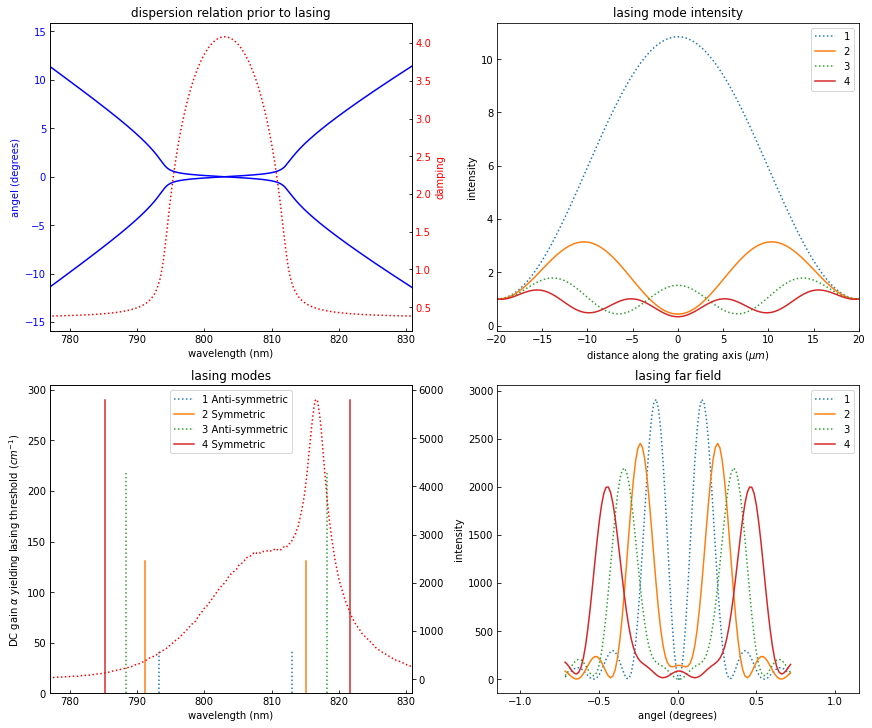

In [16]:
ax=modesfinite2(neff1=1.98-0.001j,neff2=2.09-0.001j,duty=0.25, L=40e-6,period=400e-9,asefile="77K/NDF5-6_Poldegrees9-  23.csv")
#ax[1,0].set_xlim(810,820);

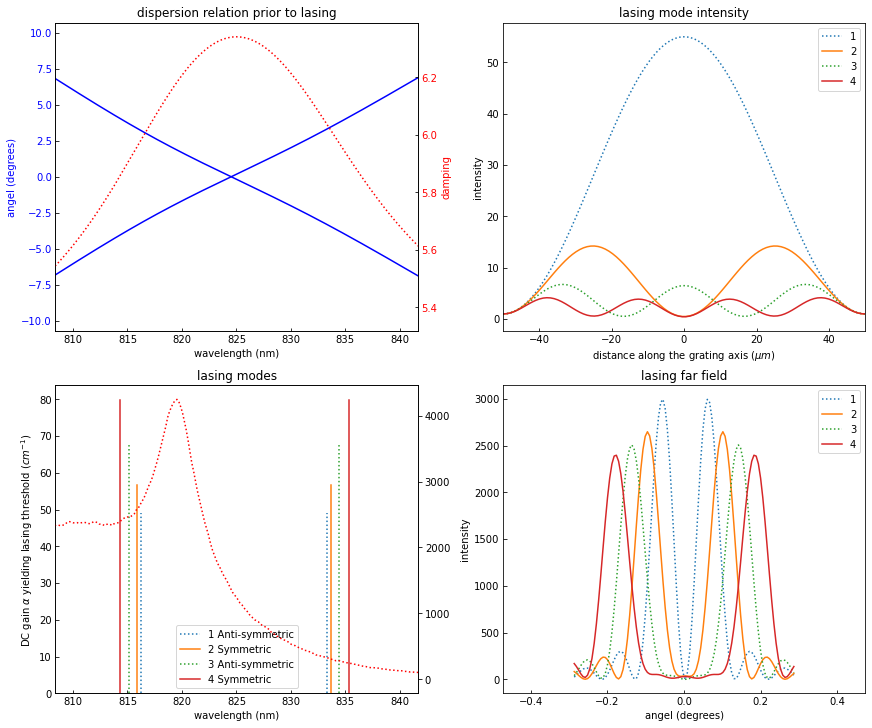

In [19]:
ax=modesfinite2(neff1=2.09+0.015j,neff2=1.985+0.012j,duty=0.27, L=100e-6,period=400e-9,asefile="100K/NDF5-6_Poldegrees9-  25.csv")
#ax[1,0].set_xlim(540,550);

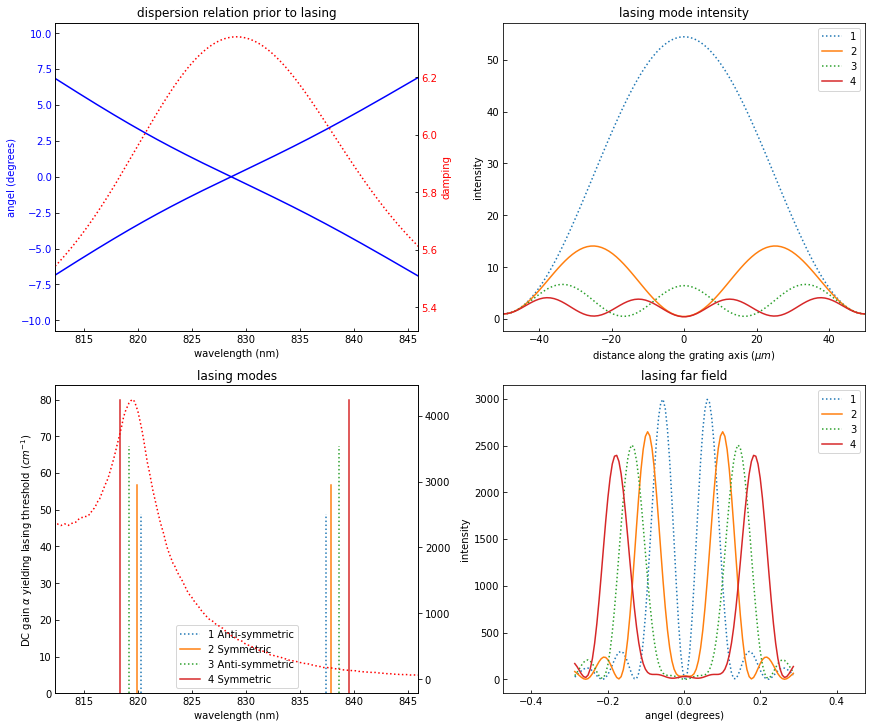

In [20]:
ax=modesfinite2(neff1=2.09+0.015j,neff2=1.985+0.012j,duty=0.27, L=100e-6,period=402e-9,asefile="100K/NDF5-6_Poldegrees9-  25.csv")

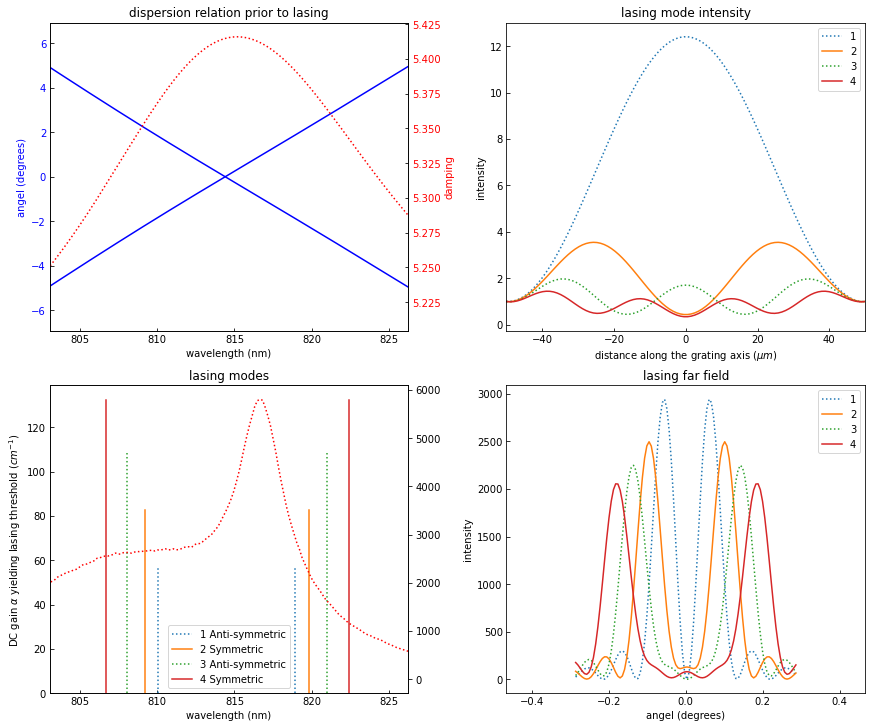

In [21]:
ax=modesfinite2(neff1=2.00+0.015j,neff2=1.95+0.012j,duty=0.27, L=100e-6,period=410e-9,asefile="77K/NDF5-6_Poldegrees9-  23.csv")

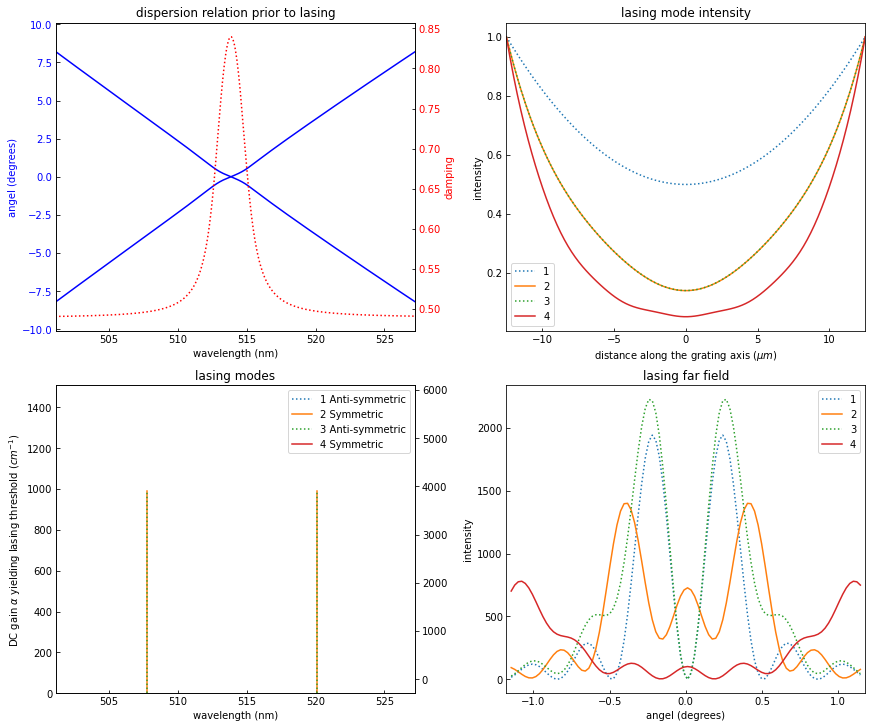

In [22]:
ax=modesfinite2(neff1=1.85+0.0015j,neff2=1.75+0.0012j,duty=0.47, L=25e-6,period=285e-9)
#ax[1,0].set_xlim(510,535);

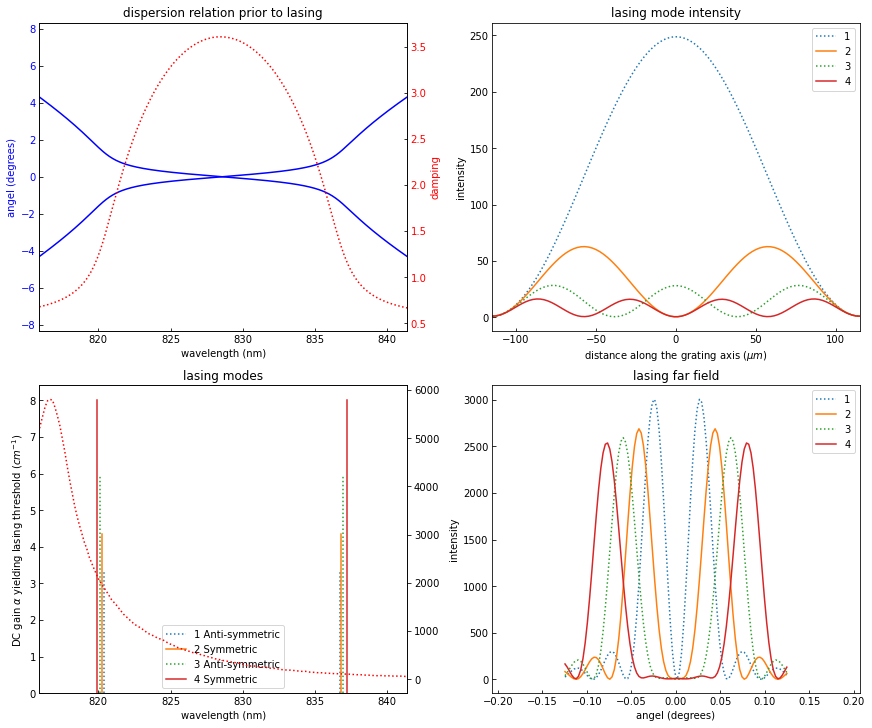

In [24]:
ax=modesfinite2(neff1=1.99+0.0015j,neff2=2.092+0.0013j,duty=0.30, L=230e-6,period=410e-9)
#ax[1,0].set_xlim(803,804);

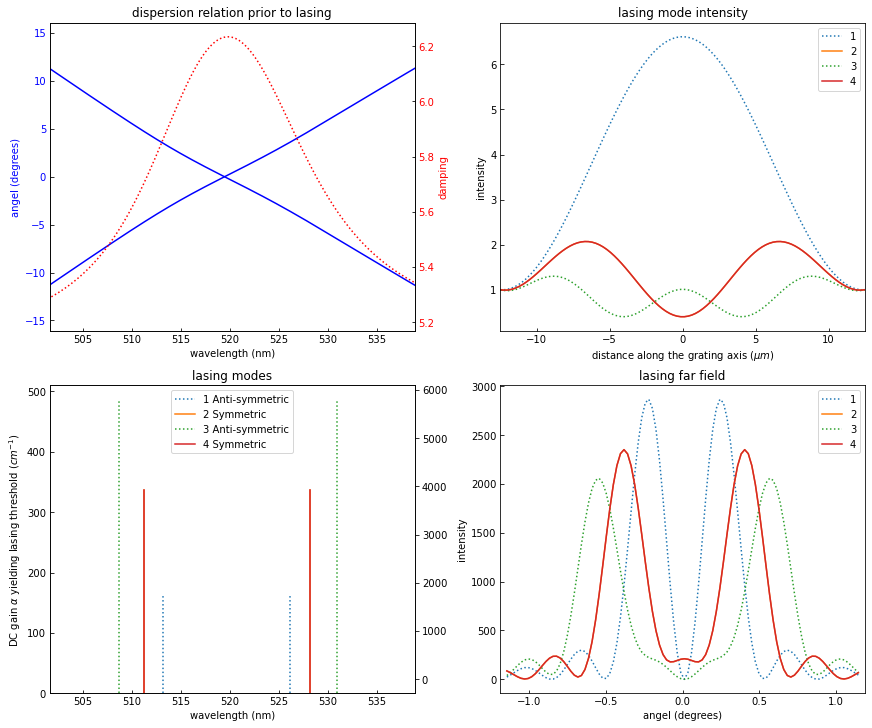

In [25]:
ax=modesfinite2(neff1=1.85+0.015j,neff2=1.75+0.012j,duty=0.27, L=25e-6,period=285e-9)
#ax[1,0].set_xlim(510,535);

Fig a above corresponds plusminus to fig 5.a (S-polarisation) from  <cite id="qdetu"><a href="#DOI|10.1002/adpr.202100177">[1]</a></cite>

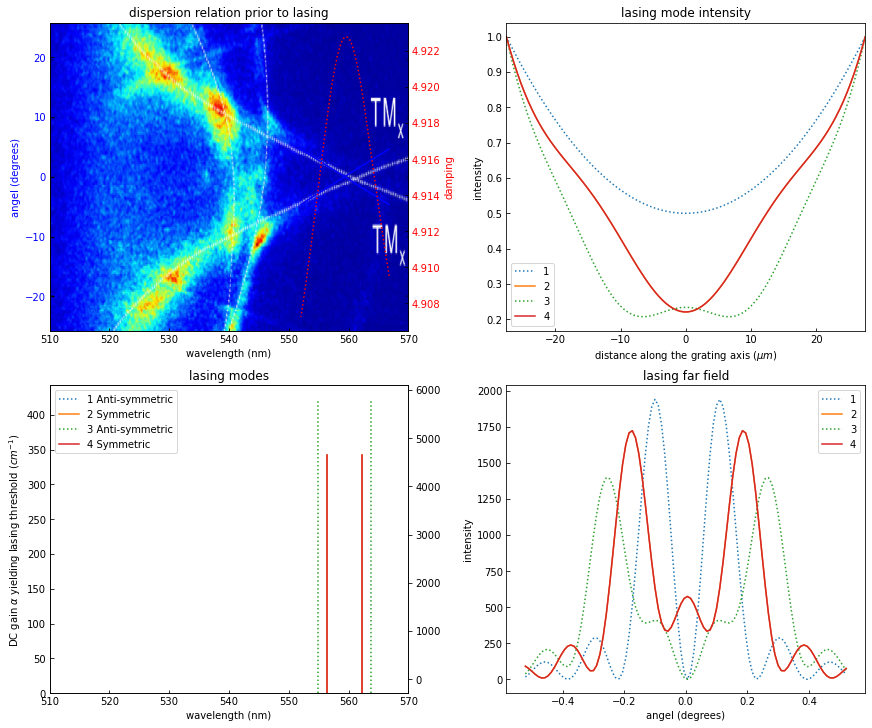

In [33]:
ax=modesfinite2(neff1=2.00+0.015j,neff2=1.92+0.012j,duty=0.47, L=55e-6,period=285e-9,dispfile="Palatnic-Leo-2021.png",minwl=510, maxwl=570, maxangle=30)
ax[0,0].set_xlim(510,570);
ax[1,0].set_xlim(510,570);

Fig a above corresponds plusminus to fig 5.c (P-polarisation) from  <cite id="en4jw"><a href="#DOI|10.1002/adpr.202100177">[1]</a></cite>

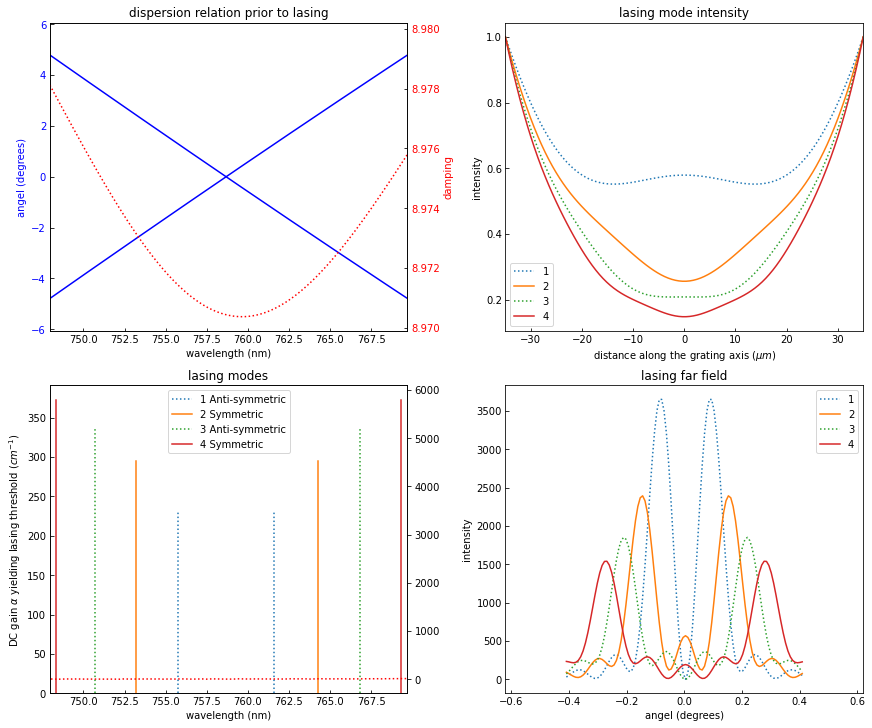

In [34]:
modesfinite2(neff1=1.85+0.03j,neff2=1.851+0.01j,L=70e-6,duty=0.25);

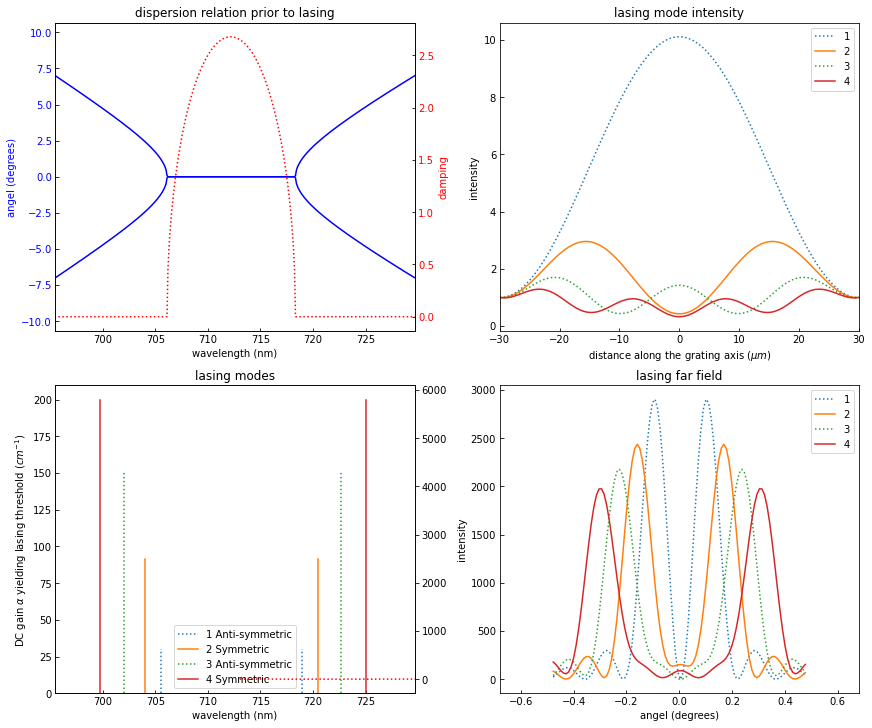

In [35]:
ax=modesfinite2(L=60e-6,duty=0.37);

# Dispersion relation



The two Coupled-Wave Equations giving the dispersion relation are:

$$ S $$

$$ R $$

with xx

$$ \alpha(z)= \alpha_0+ \alpha_1 \cos(\beta_o)+ \alpha_2 \cos(2\beta_o)  $$
$$ n(z)= n_0+ n_1 \cos(\beta_o)+ n_2 \cos(2\beta_o)  $$



as a consequence,

$$ n=  n_{eff1}+duty*(n_{eff2}-n_{eff1})$$

$$ n_1=  $$

$$ n_2 = $$

Please note that $n_2$ as defined above corresponds to $n_1$ as defined in <cite id="wiv2o"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite> to get it better in line with <cite id="ghshd"><a href="#zotero|11916217/E3RK6AMH">[3]</a></cite>


We solve the Eq. (3.28) from <cite id="vjpv8"><a href="#DOI|10.1002/0470856238">[4]</a></cite>  which gives us Fig 3.2 from <cite id="dc2nl"><a href="#DOI|10.1002/0470856238">[4]</a></cite>

$$ j \gamma L= \kappa L \sinh(\gamma L )$$

$$ \gamma^2 =(\alpha- j \delta)^2 + \kappa^2  $$

$$ (\gamma L)^2 =(\alpha L- j \delta L)^2 + (\kappa L)^2  $$

We solve for $x=\gamma L$. The equation then becomes:

$$ \kappa L \sinh(x)- j x=0$$

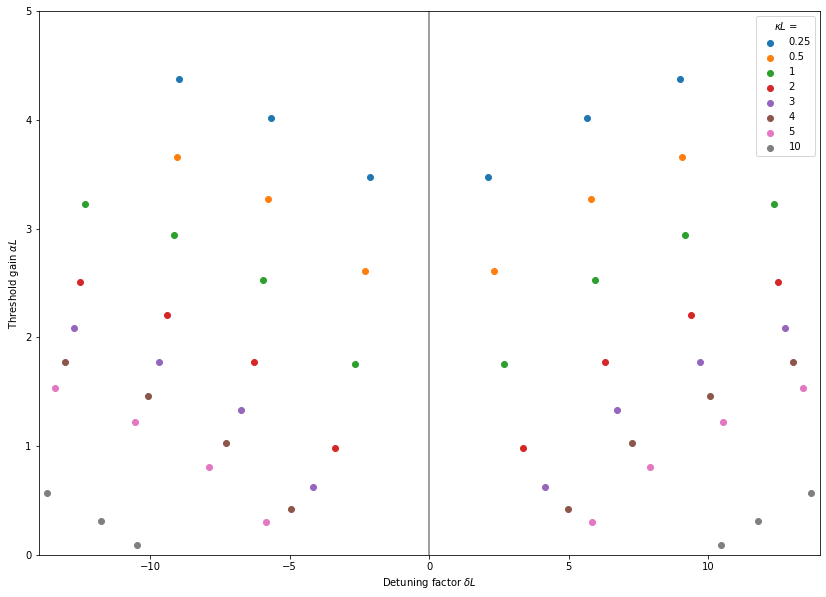

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

def fff(x,kappa):
    return kappa*np.sinh(x)-1j*x

def dfff(x,kappa):
    return kappa*np.cosh(x)-1j

def glsol(kappa,node):
    xstart=1/np.sqrt(np.sinh(kappa/np.pi)) +(node-1)/(kappa**2/40+1) +1j*node*np.pi   
    nn= newton(fff, xstart, fprime=dfff,  args=(kappa,))
    if abs(nn.imag)>node*np.pi or abs(nn.imag)<(node-1)*np.pi:
        nn=newton(fff, xstart,  args=(kappa,))
        if abs(nn.imag)>node*np.pi or abs(nn.imag)<(node-1)*np.pi:
            return "NaN"
    return np.sqrt(nn**2-kappa**2)

fig, ax = plt.subplots(figsize=(14,10))
for k in [0.25,0.5,1,2,3,4,5,10]:
    fx1=[glsol(k,node) for node in range(1,5)]
    fx=[x for x in fx1 if np.iscomplex(x) ]
    ax.scatter([abs(x.imag) for x in fx ]+[-abs(x.imag) for x in fx ],[x.real for x in fx ]+[x.real for x in fx ], label=str(k))
ax.set_xlim(-14,14)
ax.set_ylim(0,5)
ax.axvline(color="grey")
ax.set_xlabel(r"Detuning factor $\delta L$")
ax.set_ylabel(r"Threshold gain $\alpha L$")
ax.legend(title=r"$\kappa L$ =");

# ASE condition




# Lasing condition


## Under a limited grating length

We can define the lasing condition as in [xx].
In reality, we solve the Eq.

$$ x=0 $$

## Under an infinite grating length but with a limited gain length

When the gain length is limited to L, the border conditions are now defined by the reflection obtained at the edge of the gain region.




## Only gain modulation

$$ \alpha= \alpha_0+ \alpha_1 \sin(\Lambda)  $$

$$ n= n_0  $$

$$ \kappa= \frac{\alpha_1}{2} j $$

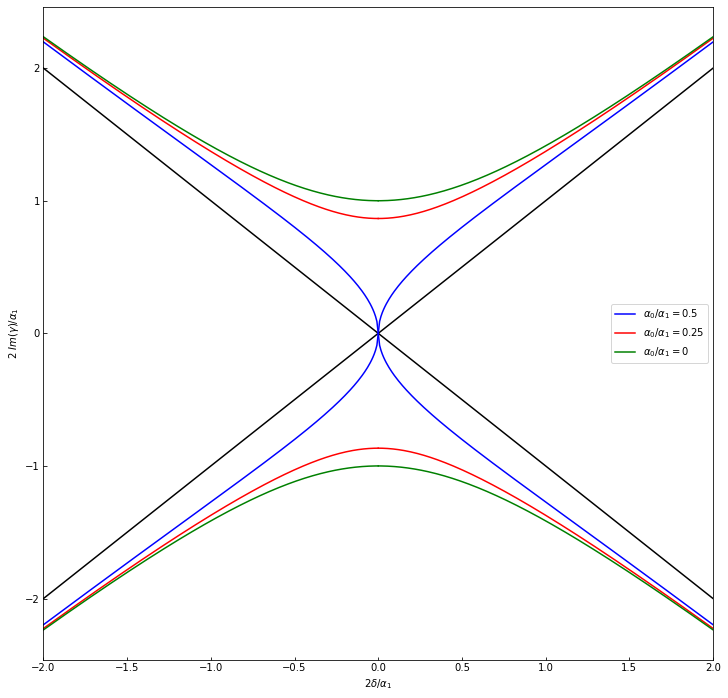

In [30]:
import numpy as np
import matplotlib.pyplot as plt

wc=np.linspace(-2,0,250)
gamma1=np.sqrt(-1+(1-1.0j*wc)**2)
gamma2=np.sqrt(-1+(1/2-1.0j*wc)**2)
gamma3=np.sqrt(-1+(-1.0j*wc)**2)
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.plot([-2,2],[-2,2],c='black')
ax.plot([-2,2],[2,-2],c='black')
ax.plot(wc,np.imag(gamma1),c='blue',label=r'$\alpha_0 / \alpha_1 =0.5 $')
ax.plot(wc,-np.imag(gamma1),c='blue');
ax.plot(-wc,np.imag(gamma1),c='blue')
ax.plot(-wc,-np.imag(gamma1),c='blue');
ax.plot(wc,np.imag(gamma2),c='red',label=r'$\alpha_0 / \alpha_1 =0.25 $')
ax.plot(wc,-np.imag(gamma2),c='red')
ax.plot(-wc,np.imag(gamma2),c='red')
ax.plot(-wc,-np.imag(gamma2),c='red');
ax.plot(wc,np.imag(gamma3),c='green',label=r'$\alpha_0 / \alpha_1 =0 $')
ax.plot(wc,-np.imag(gamma3),c='green')
ax.plot(-wc,np.imag(gamma3),c='green')
ax.plot(-wc,-np.imag(gamma3),c='green');
ax.set_xlabel(r'$2\delta / \alpha_1$')
ax.set_ylabel(r'2 $Im(\gamma) / \alpha_1$')
ax.set_xlim(-2,2)
ax.tick_params(direction='in')
plt.legend();

The figure above corresponds to Fig. 3.b of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite>


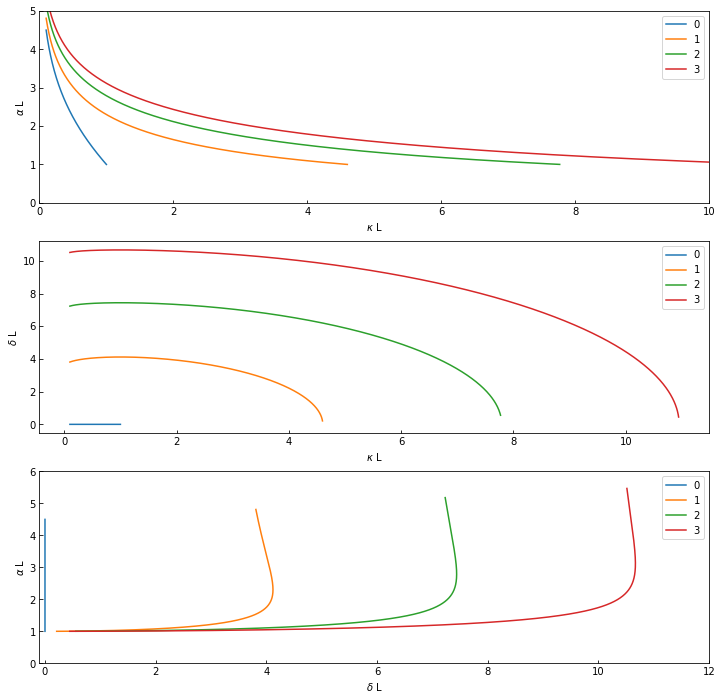

In [54]:
mode=[0,1,2,3]
aa=[0,2.9j,4.9j,6.9j]
kapaLmax=[1]+[abs(np.real((np.pi*a/2)/np.sinh(np.pi*a/2)))*0.997 for a in aa[1:] ]
fig, ax = plt.subplots(3,1,figsize=(12,12))
for mm,kLm,ar in zip(mode,kapaLmax,aa):
    testy=np.linspace(0.01,10,1500)
    testx=np.real((-1)**mm*(testy+np.pi*ar/2)/np.sinh(testy+np.pi*ar/2))
    kapaL=np.linspace(0.1,kLm,1500)
    gammaL=[optimize.newton(g, np.interp(kL, testx, testy+np.pi*ar/2), fprime=g1,fprime2=g2, args=((-1)**mm*1j*kL, )) for kL in kapaL]
    xx=(-1)**mm*kapaL*np.cosh(gammaL)
    ax[0].plot(kapaL,np.real(xx),label=str(mm))
    ax[1].plot(kapaL,np.imag(xx),label=str(mm))
    ax[2].plot(np.imag(xx),np.real(xx),label=str(mm))
ax[0].set_xlabel(r'$\kappa$ L')
ax[0].set_ylabel(r'$\alpha$ L')
ax[1].set_xlabel(r'$\kappa$ L')
ax[1].set_ylabel(r'$\delta$ L')
ax[2].set_xlabel(r'$\delta$ L')
ax[2].set_ylabel(r'$\alpha$ L')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,5)
ax[2].set_xlim(-0.1,12)
ax[2].set_ylim(0,6)
ax[0].tick_params(direction='in')
ax[1].tick_params(direction='in')
ax[2].tick_params(direction='in')
ax[0].legend();
ax[1].legend();
ax[2].legend();

The upper figure above corresponds to Fig. 9 of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite> and the lower figure above corresponds to Fig. 7 of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[1]</a></cite>



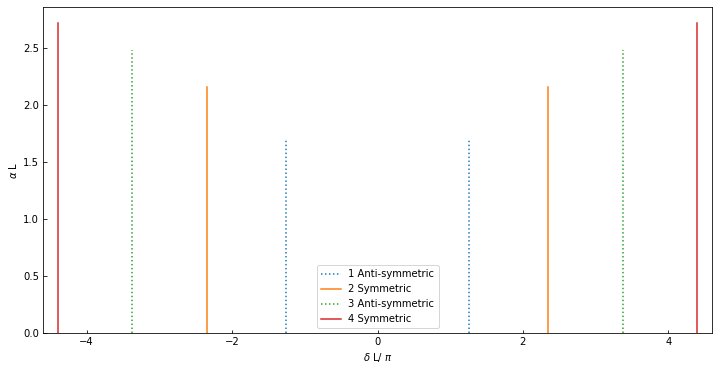

In [202]:
aa=modesfinite(kL=-1.9j)
aa.set_ylim(0,);

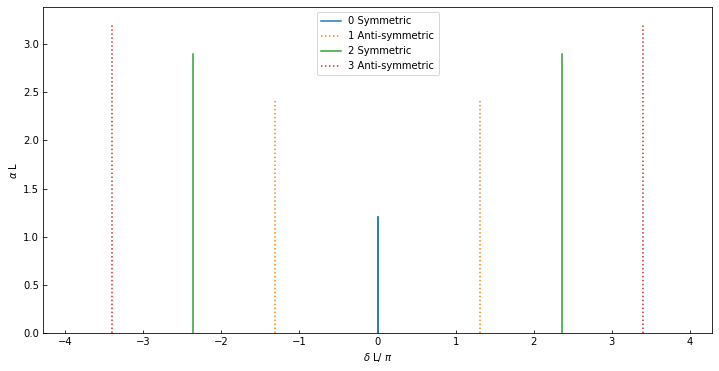

In [201]:
modesfinite(kL=-0.9j);

The figure above corresponds to Fig. 6 of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite>


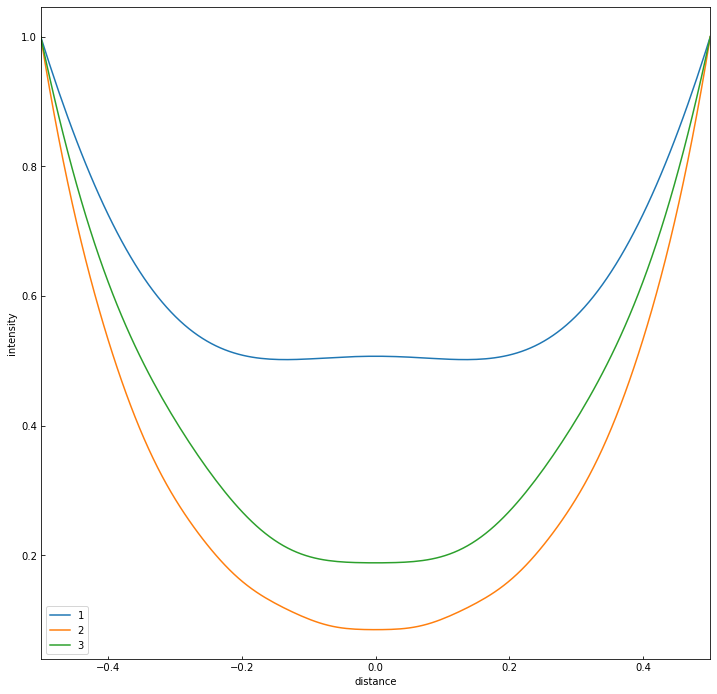

In [212]:
kL=-2j
mode=[1,2,3]
gammaL1=[optimize.newton(g,mm*(2/kL**0.5+1j*np.pi), fprime=g1,fprime2=g2, args=(kL, )) for mm in mode]

zz=np.linspace(-0.5,0.5,150)
fig, ax = plt.subplots(1,1,figsize=(12,12))
for mm,gL in zip(mode,gammaL1):
    I=np.abs(np.sinh(gL*(zz+0.5)))**2+np.abs(np.sinh(gL*(zz-0.5)))**2  
    Io=I[0]
    ax.plot(zz,I/Io,label=str(mm))

ax.set_xlabel(r'distance')
ax.set_ylabel(r'intensity')
ax.set_xlim(-0.5,0.5)
ax.tick_params(direction='in')
plt.legend();

The figure above corresponds to Fig. 12 c of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite>


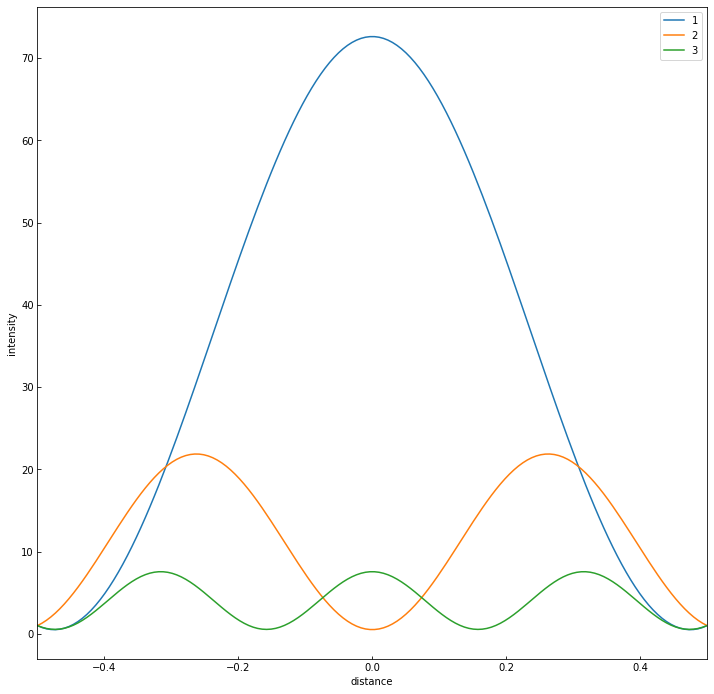

In [213]:
kL=-20j
mode=[1,2,3]
gammaL1=[optimize.newton(g,mm*(2/kL**0.5+1j*np.pi), fprime=g1,fprime2=g2, args=(kL, )) for mm in mode]

zz=np.linspace(-0.5,0.5,150)
fig, ax = plt.subplots(1,1,figsize=(12,12))
for mm,gL in zip(mode,gammaL1):
    I=np.abs(np.sinh(gL*(zz+0.5)))**2+np.abs(np.sinh(gL*(zz-0.5)))**2  
    Io=I[0]
    ax.plot(zz,I/Io,label=str(mm))

ax.set_xlabel(r'distance')
ax.set_ylabel(r'intensity')
ax.set_xlim(-0.5,0.5)
ax.tick_params(direction='in')
plt.legend();

The figure above corresponds to Fig. 12 d of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite>


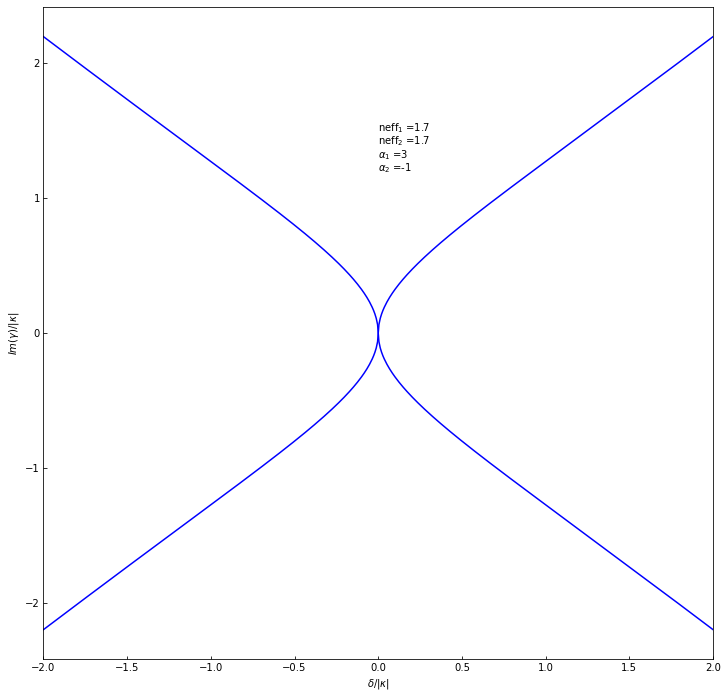

In [90]:
dispersion2(neff1=1.7,neff2=1.7,gain1=3,gain2=-1)

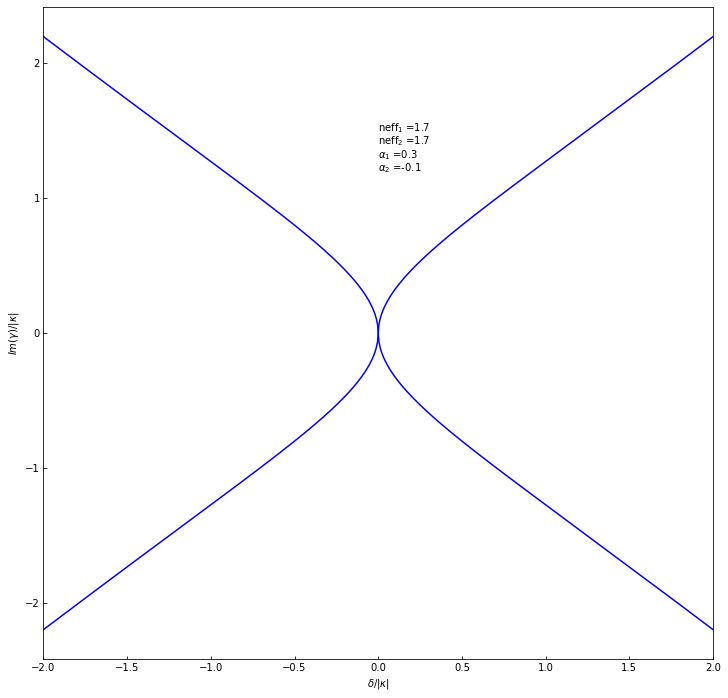

In [36]:
dispersion2(neff1=1.7,neff2=1.7,gain1=0.3,gain2=-0.1)

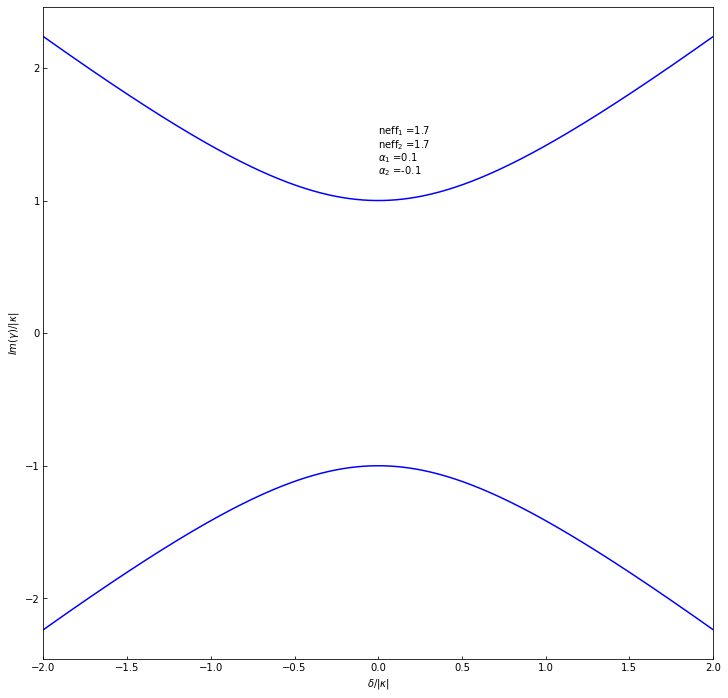

In [92]:
dispersion2(neff1=1.7,neff2=1.7,gain1=0.1,gain2=-0.1)

## Only index modulation

$$ \alpha= \alpha_0  $$

$$ n= n_0+ n_1 \sin(\Lambda)  $$

$$ \kappa= \frac{\pi n_1}{\lambda_0} $$

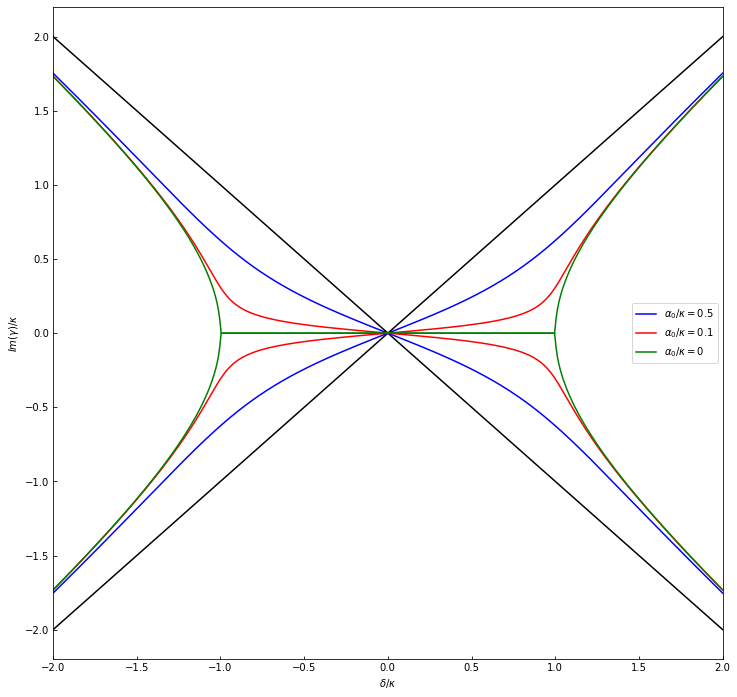

In [35]:
import numpy as np
import matplotlib.pyplot as plt


wc=np.linspace(-2,0,250)
gamma1=np.sqrt(1+(1/2-1.0j*wc)**2)
gamma2=np.sqrt(1+(1/10-1.0j*wc)**2)
gamma3=np.sqrt(1+(-1.0j*wc)**2)
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.plot([-2,2],[-2,2],c='black')
ax.plot([-2,2],[2,-2],c='black')
ax.plot(wc,np.imag(gamma1),c='blue',label=r'$\alpha_0 / \kappa =0.5 $')
ax.plot(wc,-np.imag(gamma1),c='blue');
ax.plot(-wc,np.imag(gamma1),c='blue')
ax.plot(-wc,-np.imag(gamma1),c='blue');
ax.plot(wc,np.imag(gamma2),c='red',label=r'$\alpha_0 / \kappa =0.1 $')
ax.plot(wc,-np.imag(gamma2),c='red')
ax.plot(-wc,np.imag(gamma2),c='red')
ax.plot(-wc,-np.imag(gamma2),c='red');
ax.plot(wc,np.imag(gamma3),c='green',label=r'$\alpha_0 / \kappa =0 $')
ax.plot(wc,-np.imag(gamma3),c='green')
ax.plot(-wc,np.imag(gamma3),c='green')
ax.plot(-wc,-np.imag(gamma3),c='green');
ax.set_xlabel(r'$\delta / \kappa$')
ax.set_ylabel(r'$Im(\gamma) / \kappa$')
ax.set_xlim(-2,2)
ax.tick_params(direction='in')
plt.legend();

The figure above corresponds to Fig. 3.a of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite>


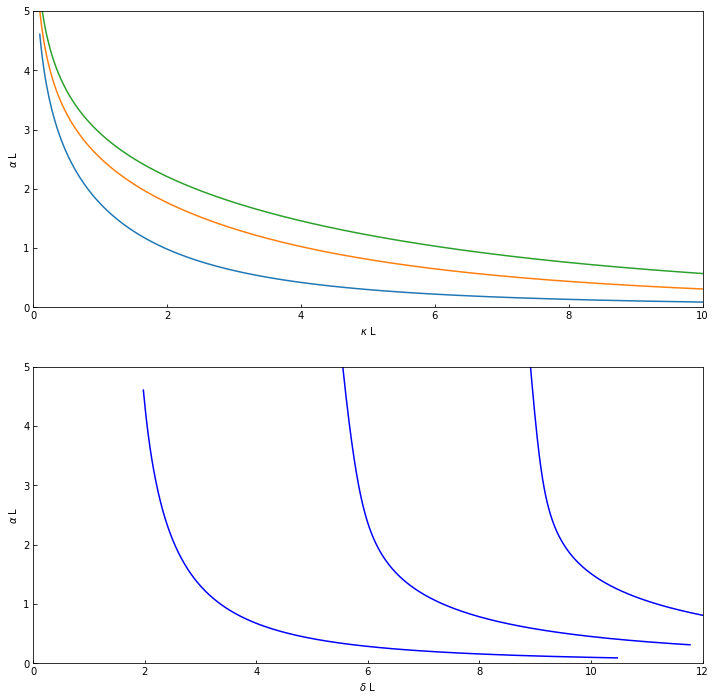

In [169]:
kapaL=np.linspace(0.1,10,500)
gammaL1=[optimize.newton(g, 2/kL**0.5+1j*np.pi, fprime=g1,fprime2=g2, args=(kL, )) for kL in kapaL]
gammaL2=[optimize.newton(g, 4/kL**0.5+2j*np.pi, fprime=g1,fprime2=g2, args=(-kL, )) for kL in kapaL]
gammaL3=[optimize.newton(g, 6/kL**0.5+3j*np.pi, fprime=g1,fprime2=g2, args=(kL, )) for kL in kapaL]
xx1=-1j*kapaL*np.cosh(gammaL1)
xx2=1j*kapaL*np.cosh(gammaL2)
xx3=-1j*kapaL*np.cosh(gammaL3)
fig, ax = plt.subplots(2,1,figsize=(12,12))
ax[0].plot(kapaL,np.real(xx1))
ax[0].plot(kapaL,np.real(xx2))
ax[0].plot(kapaL,np.real(xx3))
ax[1].plot(np.imag(xx1),np.real(xx1),c='blue');
ax[1].plot(np.imag(xx2),np.real(xx2),c='blue');
ax[1].plot(np.imag(xx3),np.real(xx3),c='blue');
ax[0].set_xlabel(r'$\kappa$ L')
ax[0].set_ylabel(r'$\alpha$ L')
ax[1].set_xlabel(r'$\delta$ L')
ax[1].set_ylabel(r'$\alpha$ L')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,5)
ax[1].set_xlim(0,12)
ax[1].set_ylim(0,5)
ax[0].tick_params(direction='in')
ax[1].tick_params(direction='in')

The upper figure above corresponds to Fig. 8 of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite> and the lower figure above corresponds to Fig. 5 of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[1]</a></cite>



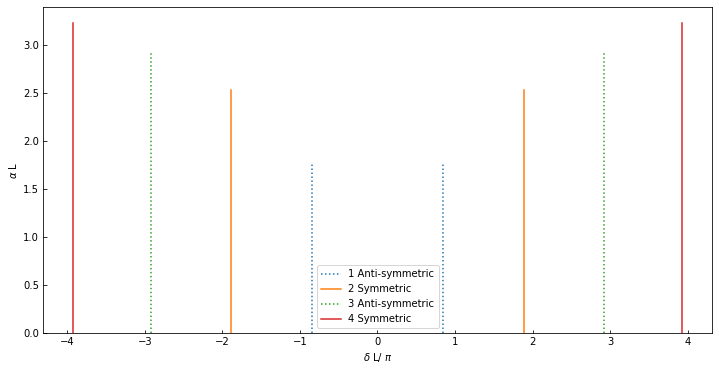

In [200]:
modesfinite(kL=1);

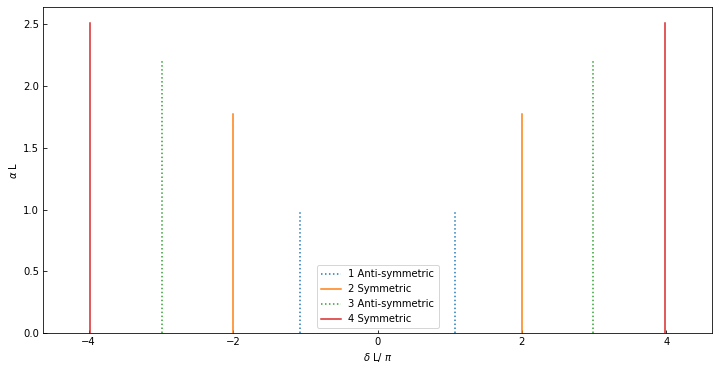

In [199]:
modesfinite(kL=2);

The upper figure above corresponds to Fig. 4 of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite> 


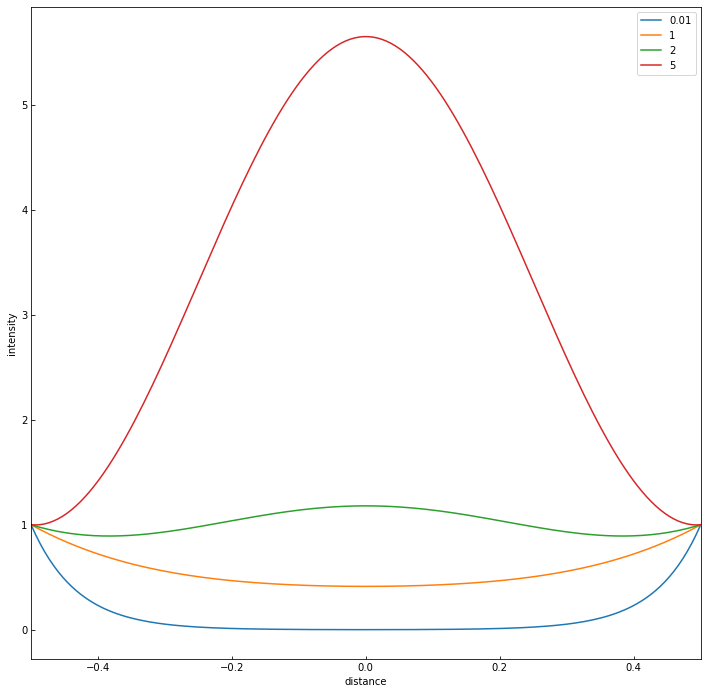

In [311]:
kapaL=[0.01,1,2,5]
gammaL1=[optimize.newton(g, 2/kL**0.5+1j*np.pi, fprime=g1,fprime2=g2, args=(kL, )) for kL in kapaL]

zz=np.linspace(-0.5,0.5,150)
fig, ax = plt.subplots(1,1,figsize=(12,12))
for kL,gL in zip(kapaL,gammaL1):
    I=np.abs(np.sinh(gL*(zz+0.5)))**2+np.abs(np.sinh(gL*(zz-0.5)))**2  
    Io=I[0]
    ax.plot(zz,I/Io,label=str(kL))

ax.set_xlabel(r'distance')
ax.set_ylabel(r'intensity')
ax.set_xlim(-0.5,0.5)
ax.tick_params(direction='in')
plt.legend();

The figure above corresponds to Fig. 10 of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite> 



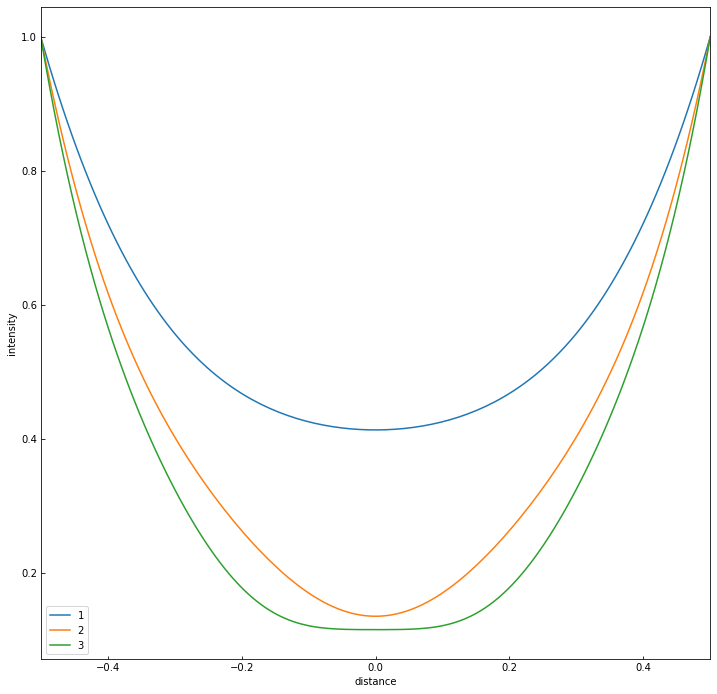

In [206]:
kL=1
mode=[1,2,3]
gammaL1=[optimize.newton(g,mm*(2/kL**0.5+1j*np.pi), fprime=g1,fprime2=g2, args=(kL, )) for mm in mode]

zz=np.linspace(-0.5,0.5,150)
fig, ax = plt.subplots(1,1,figsize=(12,12))
for mm,gL in zip(mode,gammaL1):
    I=np.abs(np.sinh(gL*(zz+0.5)))**2+np.abs(np.sinh(gL*(zz-0.5)))**2  
    Io=I[0]
    ax.plot(zz,I/Io,label=str(mm))

ax.set_xlabel(r'distance')
ax.set_ylabel(r'intensity')
ax.set_xlim(-0.5,0.5)
ax.tick_params(direction='in')
plt.legend();

The figure above corresponds to Fig. 11.c of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite> 



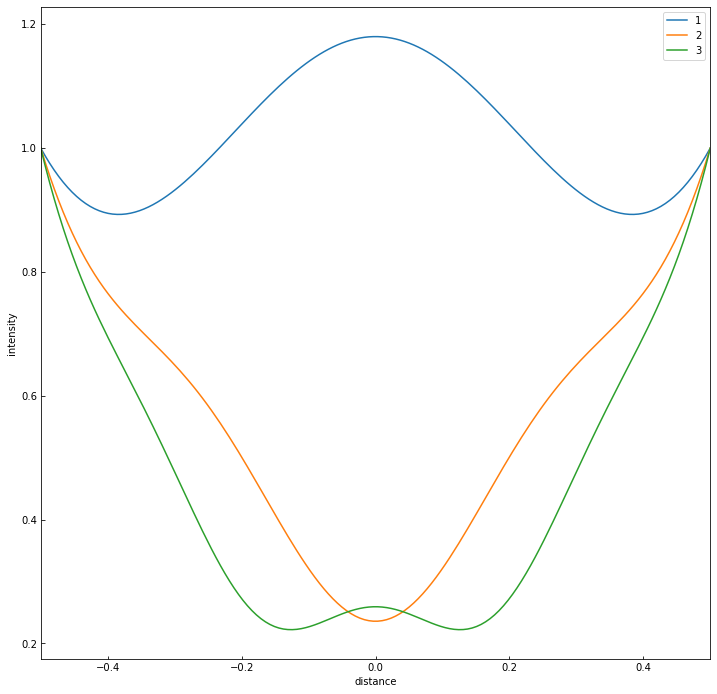

In [207]:
kL=2
mode=[1,2,3]
gammaL1=[optimize.newton(g,mm*(2/kL**0.5+1j*np.pi), fprime=g1,fprime2=g2, args=(kL, )) for mm in mode]

zz=np.linspace(-0.5,0.5,150)
fig, ax = plt.subplots(1,1,figsize=(12,12))
for mm,gL in zip(mode,gammaL1):
    I=np.abs(np.sinh(gL*(zz+0.5)))**2+np.abs(np.sinh(gL*(zz-0.5)))**2  
    Io=I[0]
    ax.plot(zz,I/Io,label=str(mm))

ax.set_xlabel(r'distance')
ax.set_ylabel(r'intensity')
ax.set_xlim(-0.5,0.5)
ax.tick_params(direction='in')
plt.legend();

The figure above corresponds to Fig. 11.b of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite> 



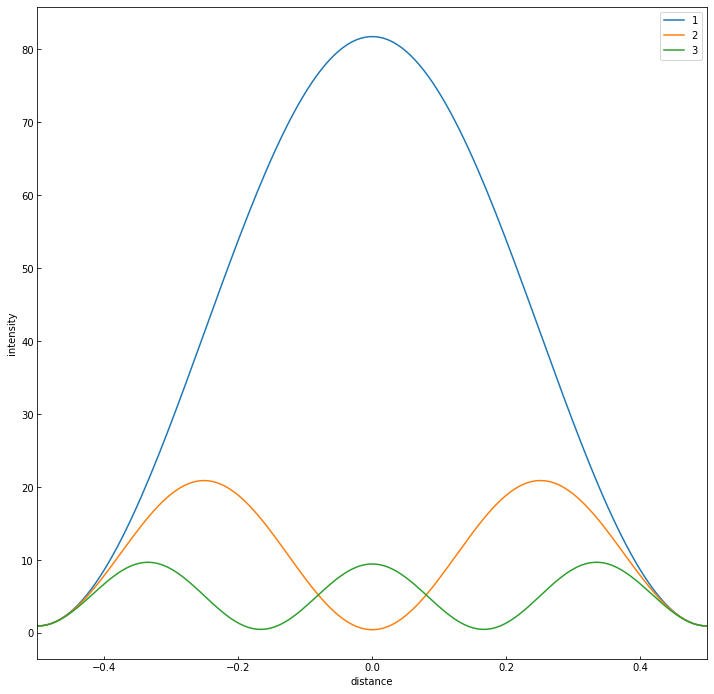

In [208]:
kL=20
mode=[1,2,3]
gammaL1=[optimize.newton(g,mm*(2/kL**0.5+1j*np.pi), fprime=g1,fprime2=g2, args=(kL, )) for mm in mode]

zz=np.linspace(-0.5,0.5,150)
fig, ax = plt.subplots(1,1,figsize=(12,12))
for mm,gL in zip(mode,gammaL1):
    I=np.abs(np.sinh(gL*(zz+0.5)))**2+np.abs(np.sinh(gL*(zz-0.5)))**2  
    Io=I[0]
    ax.plot(zz,I/Io,label=str(mm))

ax.set_xlabel(r'distance')
ax.set_ylabel(r'intensity')
ax.set_xlim(-0.5,0.5)
ax.tick_params(direction='in')
plt.legend();

The figure above corresponds to Fig. 11.d of <cite id="s3cy9"><a href="#zotero|11916217/YMBFRDQW">[2]</a></cite> 



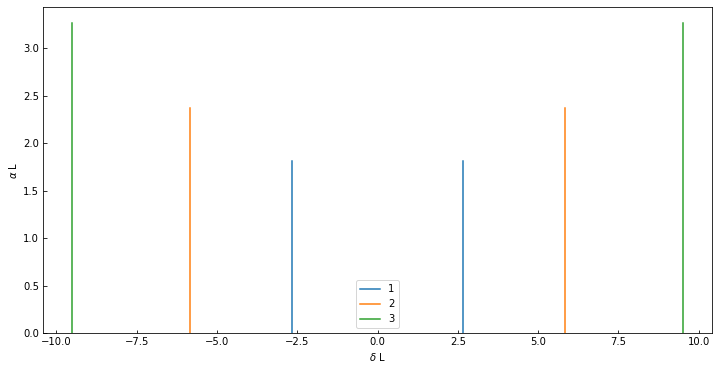

In [137]:
modesinfinite(kL=1,maxmodes=3,r1=0.0343,r2=0.0343);

The figure above corresponds to <cite id="kvhuf"><a href="#DOI|10.1002/0470856238">(H. Ghafouri–Shiraz)</a></cite> page 87



## references


<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="DOI|10.1002/adpr.202100177"></i>
    <div class="csl-left-margin">1.</div><div class="csl-right-inline">A. Palatnik, C. Cho, C. Zhang, M. Sudzius, M. Kroll, S. Meister, &#38; K. Leo, Control of Emission Characteristics of Perovskite Lasers through Optical Feedback. <i>Advanced Photonics Research</i>, <b>2</b> (2021) 2100177. <a href="https://doi.org/10.1002/adpr.202100177">https://doi.org/10.1002/adpr.202100177</a>.</div>
  </div>
  <div class="csl-entry"><i id="zotero|11916217/YMBFRDQW"></i>
    <div class="csl-left-margin">2.</div><div class="csl-right-inline">H. Kogelnik &#38; C. V. Shank, Coupled‐Wave Theory of Distributed Feedback Lasers. <i>Journal of Applied Physics</i>, <b>43</b> (1972) 2327–2335. <a href="https://doi.org/10.1063/1.1661499">https://doi.org/10.1063/1.1661499</a>.</div>
  </div>
  <div class="csl-entry"><i id="zotero|11916217/E3RK6AMH"></i>
    <div class="csl-left-margin">3.</div><div class="csl-right-inline">R. Kazarinov &#38; C. Henry, Second-order distributed feedback lasers with mode selection provided by first-order radiation losses. <i>IEEE Journal of Quantum Electronics</i>, <b>21</b> (1985) 144–150. <a href="https://doi.org/10.1109/JQE.1985.1072627">https://doi.org/10.1109/JQE.1985.1072627</a>.</div>
  </div>
  <div class="csl-entry"><i id="DOI|10.1002/0470856238"></i>
    <div class="csl-left-margin">4.</div><div class="csl-right-inline">H. Ghafouri–Shiraz, Distributed Feedback Laser Diodes and Optical Tunable Filters. (2003). <a href="https://doi.org/10.1002/0470856238">https://doi.org/10.1002/0470856238</a>.</div>
  </div>
</div>
<!-- BIBLIOGRAPHY END -->




